

Monte-Carlo Policy Gradient Algorithm [RL an Introduction by R. S. Sutton and A. G. Barto]



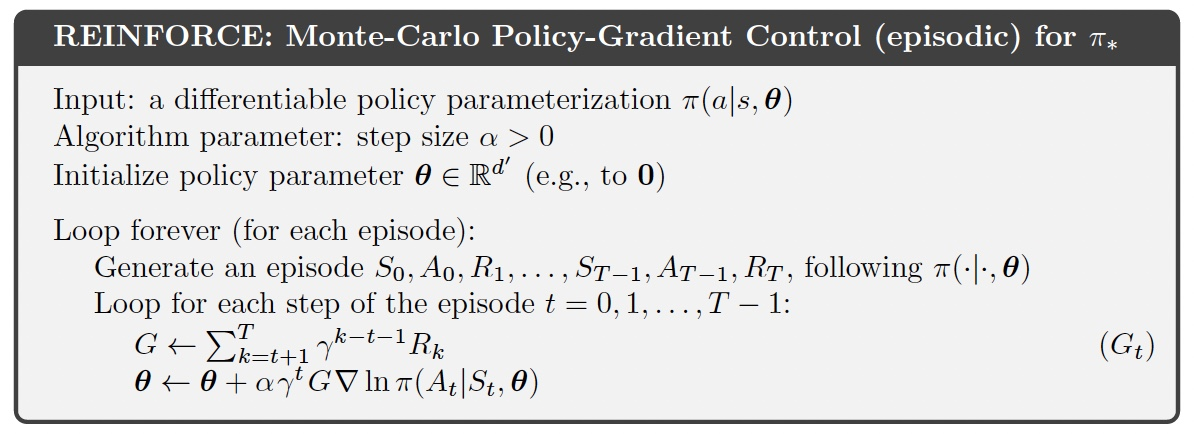

Setup the Environment and Dependencies

In [ ]:
!pip install -q swig
!pip install -q gymnasium[box2d]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 21.1 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import gym
from collections import namedtuple, deque

Display image and video

In [ ]:
from IPython.display import display, clear_output, HTML
import imageio
import base64
import matplotlib.pyplot as plt
import time

def live_plot(fig, ax, line, x, y, x_name='x', y_name='y', title_name='Data'):
    line.set_data(x, y)
    ax.set_xlabel(x_name)
    ax.set_ylabel(y_name)
    ax.set_title(f'{x_name} vs {y_name} for {title_name}')

    ax.relim()
    ax.autoscale_view()

    clear_output(wait=True) # Clear output before displaying the updated plot
    display(fig)            # Display the updated plot

def display_frames_as_gif(frames):
    """Displays a list of frames as a gif"""

    # Encode frames to video
    with imageio.get_writer('animation.mp4', mode='I', fps=60) as writer:
        for frame in frames:
            writer.append_data(frame)

    # Read video and encode to base64
    with open('animation.mp4', 'rb') as f:
        video_data = f.read()
    video_data_base64 = base64.b64encode(video_data).decode('utf-8')

    # Create HTML video element
    html = f"""
    <video width="400" height="300" controls>
        <source src="data:video/mp4;base64,{video_data_base64}" type="video/mp4">
        Your browser does not support the video tag.
    </video>
    """

    # Display the video in the notebook
    clear_output(wait=True)
    display(HTML(html))

def play_agent(env_name, agent):
    env = gym.make(env_name)
    state = env.reset()

    frames = []
    tot_rewards = 0.
    episode_len = 0
    avg_rewards = []
    avg_eps_len = []

    for _ in range(1000):
        action = agent.select_action(state)

        next_state, reward, done, _ = env.step(action)

        state = next_state

        frame = env.render(mode='rgb_array')
        frames.append(frame)

        tot_rewards += reward
        episode_len += 1
        if done:
            env.reset()
            avg_rewards.append(tot_rewards)
            avg_eps_len.append(episode_len)
            tot_rewards = 0.
            episode_len = 0

    env.close()
    display_frames_as_gif(frames)

    print('Average Reward: ', np.mean(avg_rewards))
    print('Average Episode Length: ', np.mean(avg_eps_len))

Define the Policy Network

In [ ]:
# Define the policy network
class PolicyNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, action_size)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        x = torch.softmax(self.fc3(x), dim=-1)  # Softmax for probabilities
        return x

Define the policy gradient agent. Select action and update policy

In [ ]:
# Define the policy gradient agent
class PolicyGradientAgent:
    def __init__(self, state_size, action_size, lr=0.001, gamma=0.99):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma

        self.policy_network = PolicyNetwork(state_size, action_size)
        self.optimizer = optim.Adam(self.policy_network.parameters(), lr=lr)

        self.rewards = []
        self.log_probs = []

    def select_action(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        probs = self.policy_network(state)
        action = torch.distributions.Categorical(probs).sample()
        log_prob = torch.distributions.Categorical(probs).log_prob(action)
        self.log_probs.append(log_prob)
        return action.item()

    def update_policy(self):
        discounted_rewards = self.discount_rewards(self.rewards)
        discounted_rewards = torch.tensor(discounted_rewards)
        discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-9)  # Normalize

        policy_loss = []
        for log_prob, reward in zip(self.log_probs, discounted_rewards):
            policy_loss.append(log_prob *reward)  # Negative for gradient ascent

        policy_loss = torch.cat(policy_loss).sum()

        self.optimizer.zero_grad()
        policy_loss.backward()
        self.optimizer.step()

        self.rewards = []
        self.log_probs = []

    def discount_rewards(self, rewards):
        discounted_rewards = []
        running_add = 0
        for reward in reversed(rewards):
            running_add = reward + self.gamma * running_add
            discounted_rewards.insert(0, running_add)
        return discounted_rewards

Task 1: Run the code

Task 2: Try with different values of gamma

Training Loop

In [ ]:
def learn_pg(env_name='LunarLander-v2', episodes=800):
    start_time = time.time()

    env = gym.make(env_name)
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    pg_agent = PolicyGradientAgent(state_size, action_size)

    episode_lists = [0.,]
    reward_lists = [0.,]
    fig, ax = plt.subplots()
    line, = ax.plot(episode_lists, reward_lists)

    for episode in range(episodes):
        state = env.reset()
        episode_reward = 0.

        while True:
            action = pg_agent.select_action(state)
            next_state, reward, done, _ = env.step(action)
            pg_agent.rewards.append(reward)
            episode_reward += reward
            state = next_state

            if done:
                break

        pg_agent.update_policy()

        episode_lists.append(episode)
        reward_lists.append(episode_reward)

        if episode % 50 == 0:
            live_plot(fig, ax, line, episode_lists, reward_lists, 'Episode', 'Episode Reward', f'PG in {env_name}')

    end_time = time.time()
    plt.close()
    print('Time Taken (min): ', (end_time - start_time)/60)

    return pg_agent

Task 3: Try with different values of episodes

Train the Policy

In [ ]:
%matplotlib inline

env_name = 'LunarLander-v2'
learned_agent_pg = learn_pg(env_name)

Play the learned agent

In [ ]:
%matplotlib inline

play_agent(env_name, learned_agent_pg)